In [1]:
#import SQL library
import pyodbc
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import matplotlib.ticker as ticker
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
#establishes an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LENOVO-PC\SQLEXPRESS;'
                      'Database=AdventureWorks2012;'
                      'Trusted_Connection=yes;')

In [3]:
#pull RESELLER data from SQL including Territory and Revenue 

pythonSQLobject=pd.read_sql_query("""
SELECT * FROM [dbo].[RESELLER_SELLER_FORECAST]""", conn)

conn.close() # please close it after !


In [4]:
dataset = pythonSQLobject

In [5]:
dataset.head()

,OrderDate,Revenue,Territory_Name
0,2011-05-31,2024.994,Southeast
1,2011-05-31,6074.982,Southeast
2,2011-05-31,2024.994,Southeast
3,2011-05-31,2039.994,Southeast
4,2011-05-31,2039.994,Southeast


In [6]:
dataset.shape

(60919, 3)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60919 entries, 0 to 60918
Data columns (total 3 columns):
OrderDate         60919 non-null datetime64[ns]
Revenue           60919 non-null float64
Territory_Name    60919 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


In [8]:
dataset.groupby("Territory_Name").size()

Territory_Name
Australia          1713
Canada            11444
Central            5812
France             3530
Germany            1903
Northeast          5809
Northwest          7872
Southeast          5937
Southwest         13379
United Kingdom     3520
dtype: int64

# Time Series Modeling with Prophet
## Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running

In [111]:
CA = dataset.loc[dataset['Territory_Name'] == 'Canada']
NE = dataset.loc[dataset['Territory_Name'] == 'Northeast']
NW = dataset.loc[dataset['Territory_Name'] == 'Northwest']
CA.shape, NE.shape, NW.shape

((11444, 3), (5809, 3), (7872, 3))

In [112]:
CA['OrderDate'] =  pd.to_datetime(CA['OrderDate'], format='%Y/%m')
CA = CA.sort_values(by=['OrderDate'], ascending=[True])
CA.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

NE['OrderDate'] =  pd.to_datetime(NE['OrderDate'], format='%Y/%m')
NE = NE.sort_values(by=['OrderDate'], ascending=[True])
NE.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

NW['OrderDate'] =  pd.to_datetime(NW['OrderDate'], format='%Y/%m')
NW = NW.sort_values(by=['OrderDate'], ascending=[True])
NW.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

CA.drop(["Territory_Name"],axis=1, inplace=True)
NE.drop(["Territory_Name"],axis=1, inplace=True)
NW.drop(["Territory_Name"],axis=1, inplace=True)

In [113]:
#y = df.resample('MS').mean()
y_CA = CA.resample('MS').sum()
y_NE = NE.resample('MS').sum()
z_NW = NW.resample('MS').sum()

In [114]:
y_CA

,Revenue
OrderDate,
2011-05-01,115360.896000
2011-06-01,0.000000
2011-07-01,316981.073964
2011-08-01,440548.126020
2011-09-01,0.000000
2011-10-01,640469.360300
2011-11-01,0.000000
2011-12-01,163779.833240
2012-01-01,611975.645208


In [115]:
# filling up by mean value
y_CA = y_CA['Revenue'].replace(0.000000, y_CA['Revenue'].mean())
y_NE = y_NE['Revenue'].replace(0.000000, y_NE['Revenue'].mean())
z_NW = z_NW['Revenue'].replace(0.000000, z_NW['Revenue'].mean())

In [116]:
y_CA

OrderDate
2011-05-01    115360.896000
2011-06-01    388592.583588
2011-07-01    316981.073964
2011-08-01    440548.126020
2011-09-01    388592.583588
2011-10-01    640469.360300
2011-11-01    388592.583588
2011-12-01    163779.833240
2012-01-01    611975.645208
2012-02-01    228067.733480
2012-03-01    384642.618776
2012-04-01    177981.527175
2012-05-01    638115.200822
2012-06-01    658166.939623
2012-07-01    564052.725729
2012-08-01    396580.710070
2012-09-01    510381.355637
2012-10-01    489254.910878
2012-11-01    260489.679321
2012-12-01    353871.948248
2013-01-01    394256.853148
2013-02-01    438822.401232
2013-03-01    467681.191827
2013-04-01    443495.224710
2013-05-01    501046.244487
2013-06-01    566980.382229
2013-07-01    676757.429990
2013-08-01    402367.696393
2013-09-01    433420.088498
2013-10-01    712116.283265
2013-11-01    236714.261416
2013-12-01    322799.148000
2014-01-01    464632.377218
2014-02-01    388592.583588
2014-03-01    780918.665075
2014-04-01

In [117]:
CA = pd.DataFrame({'OrderDate': y_CA.index, 'Revenue': y_CA.values})
NE = pd.DataFrame({'OrderDate': y_NE.index, 'Revenue': y_NE.values})
NW = pd.DataFrame({'OrderDate': z_NW.index, 'Revenue': z_NW.values})

In [118]:
store = CA.merge(NE,how='inner', on='OrderDate')
store.rename(columns={'Revenue_x': 'CA_revenue', 'Revenue_y': 'NE_revenue'}, inplace=True)
store.head()

,OrderDate,CA_revenue,NE_revenue
0,2011-05-01,115360.896000,21598.385500
1,2011-06-01,388592.583588,187374.108454
2,2011-07-01,316981.073964,71552.889200
3,2011-08-01,440548.126020,189511.852300
4,2011-09-01,388592.583588,187374.108454


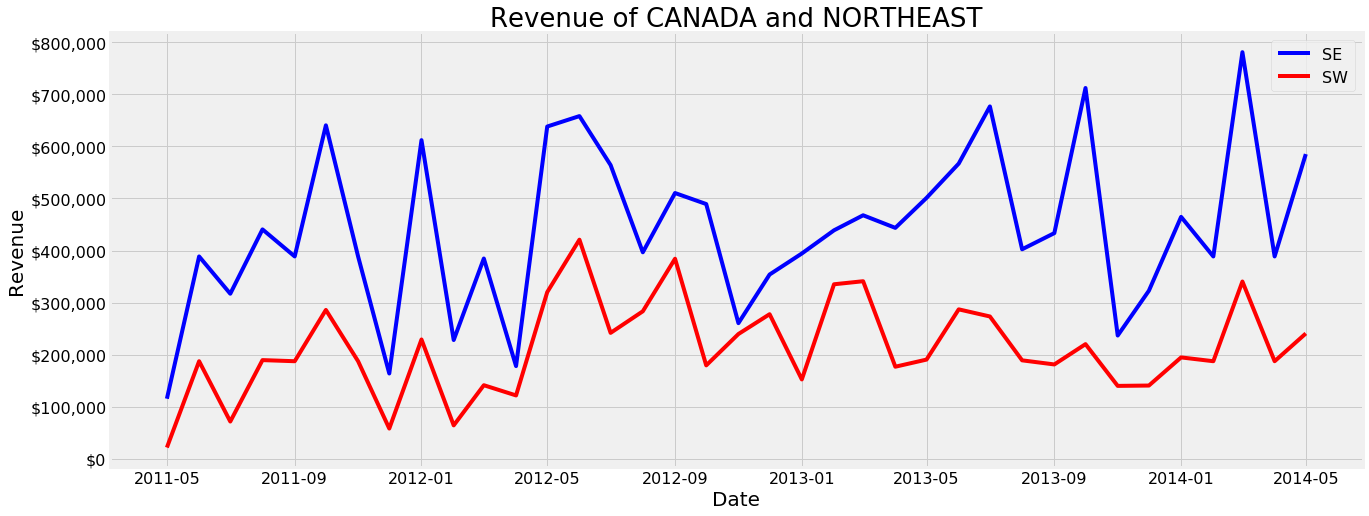

In [120]:
plt.figure(figsize=(20, 8))
plt.plot(store['OrderDate'], store['CA_revenue'], 'b-', label = 'SE')
plt.plot(store['OrderDate'], store['NE_revenue'], 'r-', label = 'SW')
plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Revenue of CANADA and NORTHEAST')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.legend();

# Fitt Model with Prophet

In [121]:
from fbprophet import Prophet
CA = CA.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
CA_model = Prophet(interval_width=0.95)
CA_model.fit(CA)

NE = NE.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
NE_model = Prophet(interval_width=0.95)
NE_model.fit(NE)

NW = NW.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
NW_model = Prophet(interval_width=0.95)
NW_model.fit(NW)

CA_forecast = CA_model.make_future_dataframe(periods=60, freq='MS')
CA_forecast = CA_model.predict(CA_forecast)

NE_forecast = NE_model.make_future_dataframe(periods=60, freq='MS')
NE_forecast = NE_model.predict(NE_forecast)

NW_forecast = NW_model.make_future_dataframe(periods=60, freq='MS')
NW_forecast = NW_model.predict(NW_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 2016x864 with 0 Axes>

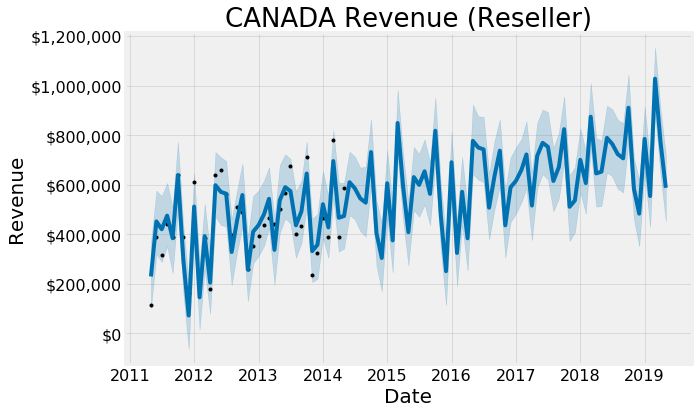

In [122]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
CA_model.plot(CA_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('CANADA Revenue (Reseller)');

<Figure size 2016x864 with 0 Axes>

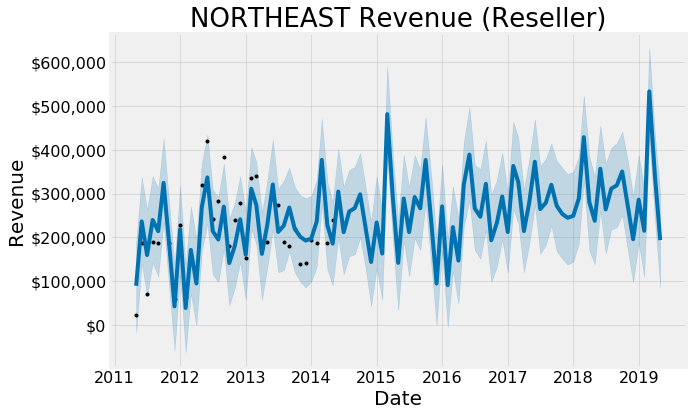

In [123]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
NE_model.plot(NE_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('NORTHEAST Revenue (Reseller)');

<Figure size 2016x864 with 0 Axes>

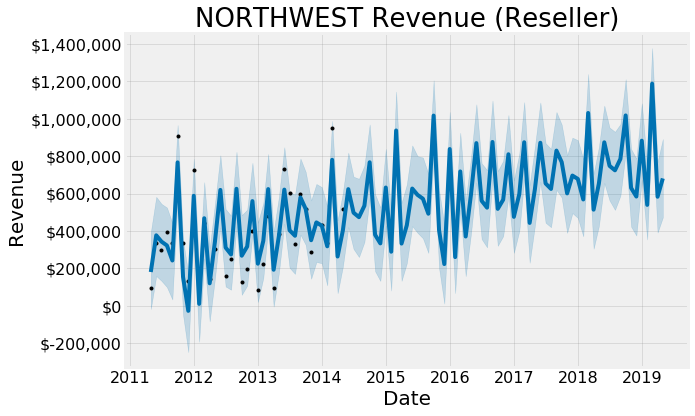

In [124]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
NW_model.plot(NW_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('NORTHWEST Revenue (Reseller)');

# Compare Forecasts
We already have the forecasts for three years for these two Teritory into the future. We will now join them together to compare their future forecasts.

In [125]:
CA_names = ['CA_%s' % column for column in CA_forecast.columns]
NE_names = ['NE_%s' % column for column in NE_forecast.columns]
NW_names = ['NW_%s' % column for column in NW_forecast.columns]

merge_CA_forecast = CA_forecast.copy()
merge_NE_forecast = NE_forecast.copy()
merge_NW_forecast = NW_forecast.copy()

merge_CA_forecast.columns = CA_names
merge_NE_forecast.columns = NE_names
merge_NW_forecast.columns = NW_names


forecast = pd.merge(merge_CA_forecast, merge_NE_forecast, how = 'inner', left_on = 'CA_ds', right_on = 'NE_ds')
forecast = forecast.rename(columns={'CA_ds': 'Date'}).drop('NE_ds', axis=1)
forecast.head()

,Date,CA_trend,CA_yhat_lower,CA_yhat_upper,CA_trend_lower,CA_trend_upper,CA_additive_terms,CA_additive_terms_lower,CA_additive_terms_upper,CA_yearly,...,NE_additive_terms,NE_additive_terms_lower,NE_additive_terms_upper,NE_yearly,NE_yearly_lower,NE_yearly_upper,NE_multiplicative_terms,NE_multiplicative_terms_lower,NE_multiplicative_terms_upper,NE_yhat
0,2011-05-01,342429.426351,102377.196246,365856.502509,342429.426351,342429.426351,-112517.333075,-112517.333075,-112517.333075,-112517.333075,...,-60871.308059,-60871.308059,-60871.308059,-60871.308059,-60871.308059,-60871.308059,0.0,0.0,0.0,89405.687726
1,2011-06-01,346224.615385,320181.859686,576908.628476,346224.615385,346224.615385,105805.767561,105805.767561,105805.767561,105805.767561,...,85104.407803,85104.407803,85104.407803,85104.407803,85104.407803,85104.407803,0.0,0.0,0.0,236504.897963
2,2011-07-01,349897.378953,288608.546461,553517.978813,349897.378953,349897.378953,70607.297246,70607.297246,70607.297246,70607.297246,...,7197.313743,7197.313743,7197.313743,7197.313743,7197.313743,7197.313743,0.0,0.0,0.0,159685.056521
3,2011-08-01,353692.567943,351431.709743,607304.170828,353692.567943,353692.567943,121700.813245,121700.813245,121700.813245,121700.813245,...,86294.027178,86294.027178,86294.027178,86294.027178,86294.027178,86294.027178,0.0,0.0,0.0,239905.264339
4,2011-09-01,357487.756932,243062.393559,508176.075603,357487.756932,357487.756932,26795.508075,26795.508075,26795.508075,26795.508075,...,59421.776012,59421.776012,59421.776012,59421.776012,59421.776012,59421.776012,0.0,0.0,0.0,214156.507559


# Trend and Forecast Visualization

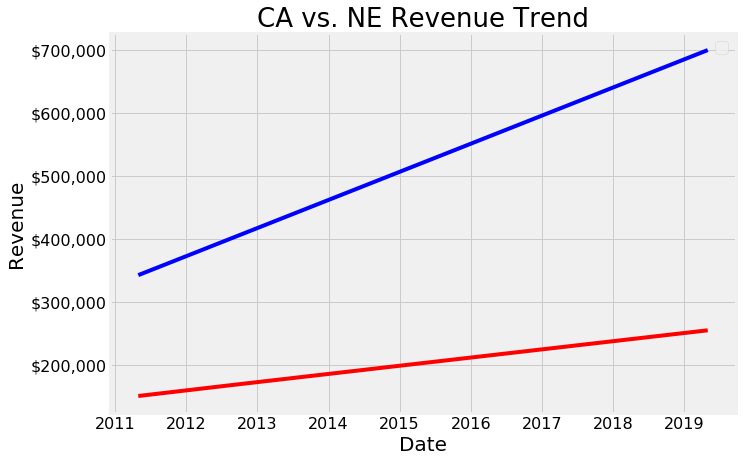

In [126]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['CA_trend'], 'b-')
plt.plot(forecast['Date'], forecast['NE_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('CA vs. NE Revenue Trend');

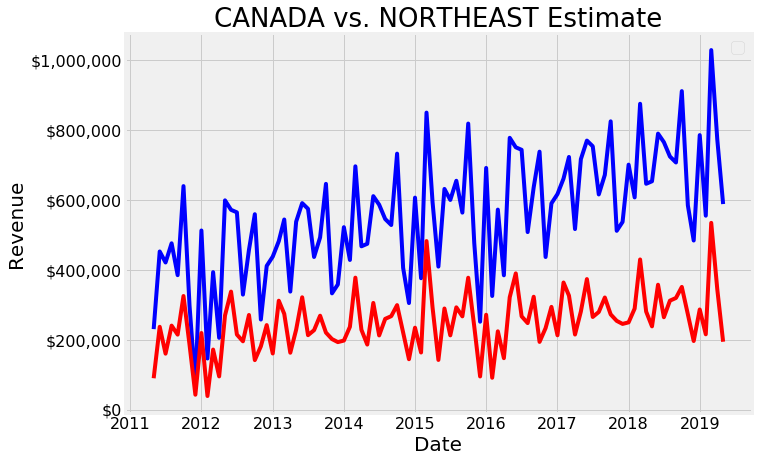

In [127]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['CA_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['NE_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('CANADA vs. NORTHEAST Estimate');

# Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two Teritory in the data.

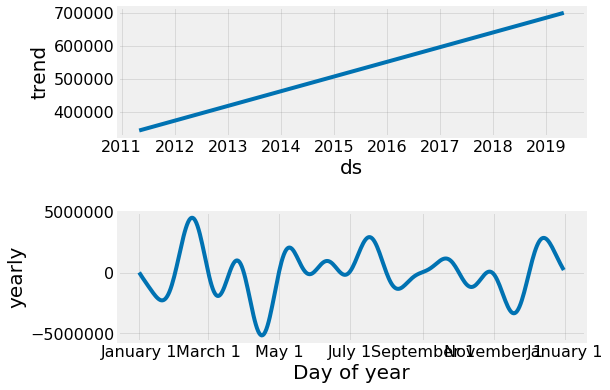

In [128]:
CA_model.plot_components(CA_forecast);

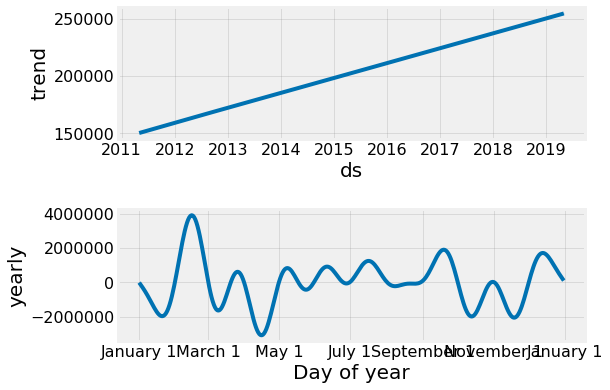

In [129]:
NE_model.plot_components(NE_forecast);

In [ ]:
NW_model.plot_components(NW_forecast);

Good to see that the revenue for both Southwest and Central have been linearly increasing over time and will be keep growing, although Southeast’ growth seems downward.
The worst month for southeasr  is October, the worst month for Southwest is November. The best month for Southeast is September, and the best month for Southwest is December.
There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started.